In [2]:
!pip install ipywidgets

  Using cached ipywidgets-7.7.0-py2.py3-none-any.whl (123 kB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached jupyterlab_widgets-1.1.0-py3-none-any.whl (245 kB)
  Using cached widgetsnbextension-3.6.0-py2.py3-none-any.whl (1.6 MB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached pyrsistent-0.18.0-cp36-cp36m-manylinux1_x86_64.whl (117 kB)
  Using cached notebook-6.4.10-py3-none-any.whl (9.9 MB)
  Using cached prometheus_client-0.14.0-py3-none-any.whl (59 kB)
  Using cached argon2_cffi-21.3.0-py3-none-any.whl (14 kB)
  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Using cached Send2Trash-1.8.0-py3-none-any.whl (18 kB)
  Using cached terminado-0.12.1-py3-none-any.whl (15 kB)
  Using cached mistune-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl (25 kB)
  Using cached bleach-4.1

In [3]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from pytz import timezone
from tqdm import tqdm
import zipfile
from pathlib import Path

# import splitfolders

plt.ion()   # 대화형 모드

In [5]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2022-04-07 13:00:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.168.129, 54.230.168.116, 54.230.168.113, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.168.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  12.2MB/s    in 3.7s    

2022-04-07 13:00:52 (12.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera

In [4]:
root_directory = Path('hymenoptera_data')
byte = sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file())
giga = round(byte/(10**9),2)

print('file size = {}GB'.format(giga))

file size = 0.05GB


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
for phase in ['train', 'val']:
    print('{}----------\n total number of images: {}, \n number of classes: {}, \n number of each classs: {}\n'.format(phase,
          len(image_datasets[phase]), len(image_datasets[phase].classes), 
          torch.unique(torch.FloatTensor(image_datasets[phase].targets), 
                       return_counts=True)[1].tolist()))

train----------
 total number of images: 244, 
 number of classes: 2, 
 number of each classs: [123, 121]

val----------
 total number of images: 153, 
 number of classes: 2, 
 number of each classs: [70, 83]



[2022-04-08 06:21:46.931 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:67 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-08 06:21:46.969 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:67 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


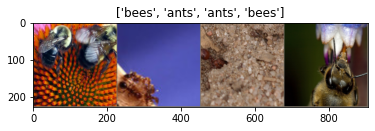

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        start_time = time.time()
        
        start = datetime.now(timezone('Asia/Seoul')
                            ).strftime('%Y-%m-%d %H:%M:%S')
        print('Start = {}'.format(start))

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]*100

            print('{:10}: Loss - {:10.4f} | Acc - {:10.2f}%'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        finish = datetime.now(timezone('Asia/Seoul')
                            ).strftime('%Y-%m-%d %H:%M:%S')
        print('Finish = {}'.format(finish))
        
        time_elapsed = time.time() - start_time
        print('Time: {:10.2f}m'.format(time_elapsed/60))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:10.0f}hr {:10.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600)/60))
    print('Best val Acc: {:10.2f}%'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7,
                                       gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
Start = 2022-04-08 15:22:10
train     : Loss -     4.5041 | Acc -      50.41%
val       : Loss -     3.4403 | Acc -      55.56%
Finish = 2022-04-08 15:22:14
Time:       0.08m

Epoch 1/1
----------
Start = 2022-04-08 15:22:14
train     : Loss -     2.5813 | Acc -      50.00%
val       : Loss -     0.8350 | Acc -      44.44%
Finish = 2022-04-08 15:22:17
Time:       0.05m

Training complete in          0hr          0s
Best val Acc:      55.56%


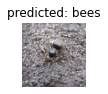

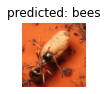

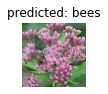

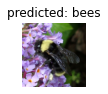

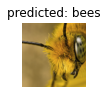

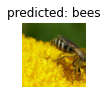

In [10]:
visualize_model(model_ft)

plt.ioff()
plt.show()